In [1]:
import pandas as pd, numpy as np, tsam.timeseriesaggregation as tsam, matplotlib.pyplot as plt

In [2]:
df_load = pd.read_csv("../../data/LoadProfile.csv")
df_load

,Load Profile
0,1355.3
1,1319.9
2,1323.8
3,1294.6
4,1351.7
...,...
8755,1234.2
8756,1283.6
8757,1306.4
8758,1327.6


In [3]:
df0 = pd.DataFrame()
price_dict = {"high"}
price_type = "high"
for price_type in ["low","high"]:
    df = pd.read_csv(f"../../data/price_{price_type}.csv").melt().rename(columns={"value":"price", "variable" : "year"})
    df["scenario_price"] = price_type
    df0 = pd.concat([df,df0],axis = 0)


df = pd.DataFrame((df0.loc[df0["scenario_price"] == "low", "price"] + df0.loc[df0["scenario_price"] == "high", "price"]) / 2)
df["scenario_price"] = "mid"
df["year"] = df0.loc[df0["scenario_price"] == "low", "year"]
df0 = pd.concat([df,df0],axis = 0)
df0["year"] = df0["year"].astype(int)
df = df0[df0['year'].isin([2025,2030,2035,2040,2045,2050])]

df_load_repeated = pd.concat([df_load] * (3 * 6), ignore_index=True)
df['Load Profile'] = df_load_repeated['Load Profile'].values

In [4]:
# Assuming typPeriods is your DataFrame with MultiIndex
def plot_multiindex_data(typPeriods):
    # Get unique values for coloring and x-axis
    first_level_values = typPeriods.index.get_level_values(0).unique()
    second_level_values = typPeriods.index.get_level_values(1).unique()
    columns = typPeriods.columns
    
    # Create subplots - one for each column
    fig, axes = plt.subplots(len(columns), 1, figsize=(12, 4*len(columns)))
    if len(columns) == 1:
        axes = [axes]
    
    # Create consistent color mapping for first index level
    colors = plt.cm.Set3(np.linspace(0, 1, len(first_level_values)))
    color_map = dict(zip(first_level_values, colors))
    
    # Plot each column in a separate subplot
    for ax_idx, column in enumerate(columns):
        ax = axes[ax_idx]
        
        # Plot each first-level index with consistent color
        for first_level in first_level_values:
            color = color_map[first_level]
            
            # Get data for this first-level index
            mask = typPeriods.index.get_level_values(0) == first_level
            subset = typPeriods[mask][column]
            
            # Plot with second level as x-axis
            x_positions = range(len(second_level_values))
            ax.plot(x_positions, subset.values, 
                   marker='o', linewidth=2, markersize=6,
                   color=color, label=f'{first_level}')
        
        ax.set_title(f'{column}')
        ax.set_xlabel('Second Index Level')
        ax.set_ylabel('Values')
        ax.set_xticks(range(len(second_level_values)))
        ax.set_xticklabels(second_level_values)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()

In [19]:
hoursPerPeriod = 24 # hours
noTypicalPeriods = 8

type_periods = pd.DataFrame

df_all_weeks = pd.DataFrame()
df_all_weights = pd.DataFrame()
df_all_metrics = pd.DataFrame()

for year in df["year"].unique():
    for scen in df["scenario_price"].unique():
        to_aggregate = df[(df["year"] == year) & (df["scenario_price"] == scen)]
        aggregation = tsam.TimeSeriesAggregation(to_aggregate[["Load Profile","price"]],
            resolution = 1,
            noTypicalPeriods = noTypicalPeriods,
            hoursPerPeriod = hoursPerPeriod,
            segmentation = False,
            # noSegments = 6,
            representationMethod = "distributionAndMinMaxRepresentation",
            # distributionPeriodWise = False
            clusterMethod = 'hierarchical',
            addPeakMax = ["Load Profile"]
        )
        typPeriods = aggregation.createTypicalPeriods()
        weights = pd.DataFrame([aggregation.clusterPeriodNoOccur])
        # plot_multiindex_data(typPeriods)
        accuracy = aggregation.accuracyIndicators()
        print(accuracy)
        df_unstacked = typPeriods.reset_index().rename(columns = {"level_0":"period","TimeStep":"hour"})

        info_accuracy = accuracy.copy().reset_index().rename(columns={'index': 'ts_type'})
        info_accuracy["year"] = year
        info_accuracy["scenario_price"] = scen
        df_unstacked["year"] = year
        df_unstacked["scenario_price"] = scen
        weights["year"] = year
        weights["scenario_price"] = scen

        df_all_weeks = pd.concat([df_unstacked,df_all_weeks],axis = 0)
        df_all_metrics = pd.concat([df_all_metrics,info_accuracy])
        df_all_weights = pd.concat([df_all_weights,weights])
    #     break
    # break

df_all_weeks.to_csv("../../data/preprocessed/typical_periods_all.csv")
df_all_metrics.to_csv("../../data/preprocessed/typical_metrics_all.csv")
df_all_weights.to_csv("../../data/preprocessed/typical_weights_all.csv")

                  RMSE  RMSE_duration       MAE
Load Profile  0.089307       0.005062  0.063852
price         0.074773       0.012085  0.054987
                  RMSE  RMSE_duration       MAE
Load Profile  0.088975       0.005236  0.065275
price         0.073464       0.010670  0.054288
                  RMSE  RMSE_duration       MAE
Load Profile  0.077952       0.005101  0.057696
price         0.080785       0.008497  0.061550
                  RMSE  RMSE_duration       MAE
Load Profile  0.088790       0.004975  0.063578
price         0.074866       0.011803  0.055061
                  RMSE  RMSE_duration       MAE
Load Profile  0.088975       0.005236  0.065275
price         0.073464       0.010670  0.054288
                  RMSE  RMSE_duration       MAE
Load Profile  0.077952       0.005101  0.057696
price         0.080785       0.008497  0.061550
                  RMSE  RMSE_duration       MAE
Load Profile  0.091516       0.005030  0.064135
price         0.067964       0.008948  0

     period  hour  Load Profile        price  year scenario_price
0         0     0    667.782243   359.707663  2030           high
1         0     1    640.067758   326.809833  2030           high
2         0     2    547.028198   292.716536  2030           high
3         0     3    564.543019   142.577480  2030           high
4         0     4    694.385019   249.719119  2030           high
..      ...   ...           ...          ...   ...            ...
187       7    19    931.465575  1720.645282  2030           high
188       7    20    985.788959  1698.542054  2030           high
189       7    21    966.059437  1629.823085  2030           high
190       7    22   1011.478041  1460.098242  2030           high
191       7    23   1032.536177  1412.412722  2030           high

[192 rows x 6 columns]


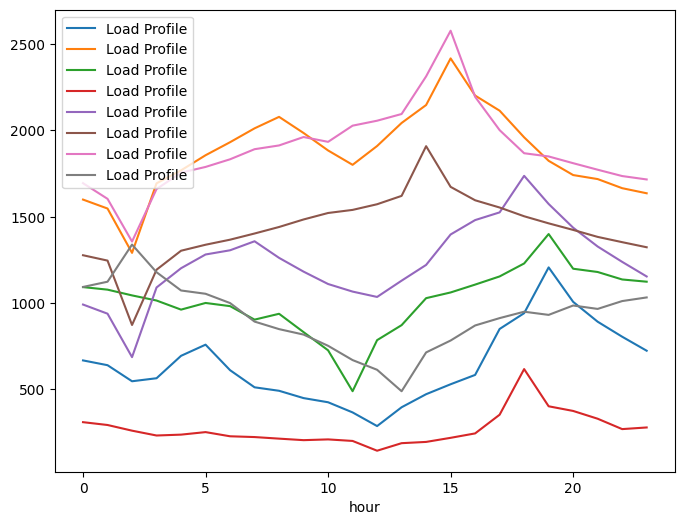

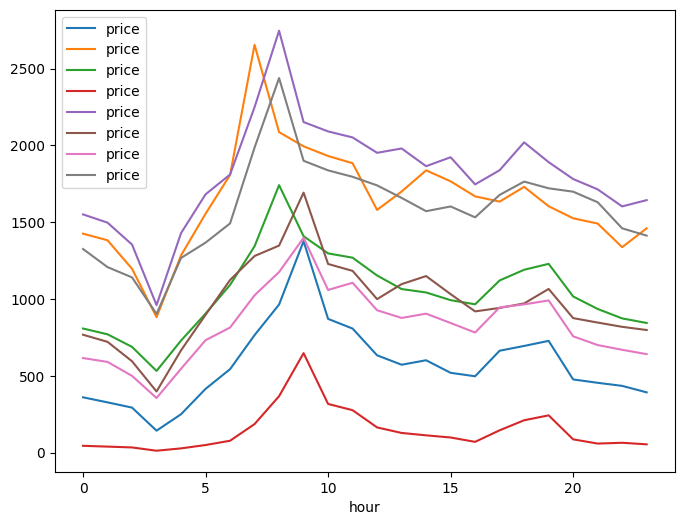

In [24]:
mask = (df_all_weeks["year"] == 2030) * (df_all_weeks["scenario_price"] == "high")
print(df_all_weeks[mask])
# df_all_weeks[mask].plot(x="hour",y=["Load Profile"], by=["typical_week"])
fig, ax = plt.subplots(figsize=(8,6))
bp = df_all_weeks[mask].groupby('period').plot(x="hour",y=["Load Profile"], ax = ax)
fig, ax = plt.subplots(figsize=(8,6))
bp = df_all_weeks[mask].groupby('period').plot(x="hour",y=["price"], ax = ax)